# Distributed optimization algorithms
The goal of this notebook is to work on distributed optimization algorithms, which are the foundation for large scale analytics and machine learning. Specifically, we will focus on the details of stochastic gradient descent (SGD). To do so, we will work on a simple regression problem, where we will apply SGD to minimize a loss function, as defined for the problem at hand. The emphasis of this laboratory is **not** on the machine learning part: even if you've never worked on regression problems, this shouldn't prevent you from being successful in developing the Notebook.

Next, an outline of the steps we will follow in this Notebook:

* Brief introduction to linear regression
* Implementation of serial algorithms: from Gradient Descent, to Stochastic Gradient Descent
* Implementation of distributed algorithms with Apache Spark


### Initialization code

In [1]:
%matplotlib inline
import sys
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import datetime as datetime

from scipy import stats 

from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

from sklearn.datasets.samples_generator import make_regression

## A simple example: linear regression
Let’s see briefly how to use gradient descent in a simple least squares regression setting. Asssume we have an output variable $y$ which we think depends linearly on the input vector $x$. That is, we have:

$$x = \begin{bmatrix}x_1 \\ x_2 \\ \cdots \\ x_m\end{bmatrix}, y = \begin{bmatrix}y_1 \\ y_2 \\ \cdots \\ y_m\end{bmatrix}$$

We approximate $y_i$ by:

$$ f_{\theta}(x_i) = \theta_1 + \theta_2 x_i$$

Define the loss function for the simple linear least squares regression as follows:

$$ J(\theta) = \frac{1}{2} \sum_{i=1}^{m}(f_{\theta}(x_i) - y_i)^2$$

Now, let's use scikit learn to create a regression problem. A few notes are in order:

* The call to ```make_regression``` essentially generates samples for a regression problem
* The call to ```stats.linegress``` calculates a linear least-squares regression for two sets of measurements

This means we have a sort of "basline" to experiment with our SGD implementation.

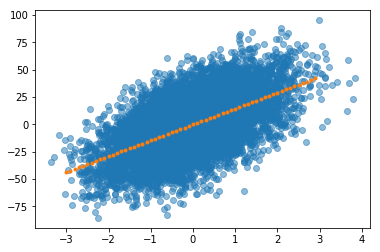

In [2]:
x, y = make_regression(n_samples = 10000, 
                       n_features=1, 
                       n_informative=1, 
                       noise=20,
                       random_state=2017)
x = x.flatten()
slope, intercept,_,_,_ = stats.linregress(x,y)
best_fit = np.vectorize(lambda x: x * slope + intercept)
plt.plot(x,y, 'o', alpha=0.5)
grid = np.arange(-3,3,0.1)
plt.plot(grid,best_fit(grid), '.')


## Batch gradient descent
Before delving into SGD, let's take a simpler approach. Assume that we have a vector of paramters $\theta$ and a loss function $J(\theta)$, which we want to minimize. The loss function we defined above has the form:

$$ J(\theta) = \sum_{i=1}^{m} J_i(\theta)$$

where $J_i$ is associated with the i-th observation in our data set, such as the one we generated above. The batch gradient descent algorithm, starts with some initial feasible parameter $\theta$ (which we can either fix or assign randomly) and then repeatedly performs the update:

$$ \theta^{(t+1)} = \theta^{(t)} - \eta \nabla_{\theta} J(\theta^{(t)}) = \theta^{(t)} - \eta \sum_{i=1}^{m} \nabla_{\theta} J_i(\theta^{(t)}) $$

where $t$ is an iteration index, and $\eta$ is a constant controlling step-size and is called the learning rate. Note that in order to make a **single update**, we need to calculate the gradient **using the entire dataset**. This can be very inefficient for large datasets, and it is the goal of this Notebook to insist on this aspect.

In code, the main loop for batch gradient descent looks like this:

```python
for i in range(n_epochs):
  params_grad = evaluate_gradient(loss_function, data, params)
  params = params - learning_rate * params_grad
```

For a given number of iterations (also called epochs) $n_{e}$ , we first evaluate the gradient vector of the loss function using **ALL** examples in the data set, and then we update the parameters with a given learning rate. Batch gradient descent is guaranteed to converge to the global minimum for convex loss surfaces and to a local minimum for non-convex surfaces.

<div class="alert alert-warning">
<b>NOTE:</b> Who computes the gradient?
<br>
<br>
Given a loss function $J(\theta)$, the gradient with respect to paramters $\theta$ must be derived manually. In other words, given the expression of $J(\theta)$, pencil and paper are required to derive the analytical form of its gradient. Then this expression can be plugged into our code.

Recently, machine learning libraries have adopted the techniques of **automatic differentiation**, which eliminate this tedious and error prone step. Given a loss function $J(\theta)$, such libraries automatically compute the gradient.
</div>


For the linear regression case, let's derive the update step for gradient descent. Recall that we have defined:

$$ J(\theta) = \frac{1}{2} \sum_{i=1}^{m}(f_{\theta}(x_i) - y_i)^2$$

$$f_\theta(x_i) = \theta_1 + \theta_2 x_i$$

So we have that:

$$ \nabla_\theta J(\theta) = \frac{1}{2} \sum_{i=1}^{m} \nabla_\theta (\theta_1 + \theta_2 x_i - y_i)^2 $$

If we explicit the partial derivatives of the gradient, we have:

$$\frac{\partial J(\theta)}{\partial \theta_1} = \sum_{i=1}^{m} (\theta_1 + \theta_2 x_i - y_i)$$
$$\frac{\partial J(\theta)}{\partial \theta_2} = \sum_{i=1}^{m} (\theta_1 + \theta_2 x_i - y_i) x_i$$

So now we can explicit the update rules for the two model parameters:

$$ \theta_1^{(t+1)} = \theta_1^{(t)} - \eta \sum_{i=1}^{m}  (\theta_1^{(t)} + \theta_2^{(t)} x_i - y_i)$$

$$ \theta_2^{(t+1)} = \theta_2^{(t)} - \eta \sum_{i=1}^{m}  (\theta_1^{(t)} + \theta_2^{(t)} x_i - y_i) x_i$$


### Using matrix notation
Now, before writing some code, let's see how can we simplify the above expressions using matrices. Note that this is not only useful for working on a more compact notation, but it helps reason about efficient computations using libraries such as numpy, which we will use extensively.

We firstly expressed our prediction as: $f_\theta (x_i) = \theta_1 + \theta_2 x_i$. Let's introduce a surrogate dimension for our input set $x$, such that:

$$x = 
\begin{bmatrix} 1& x_{1} \\ 1 & x_{2} \\ \cdots & \cdots \\ 1 & x_{m}\end{bmatrix}
$$

where we define, with a small abuse of notation, $x_i = \begin{bmatrix} 1 & x_{i}\end{bmatrix}$. Also, let's define vector $\theta = \begin{bmatrix} \theta_1 \\ \theta_2\end{bmatrix}$. 

Then, we can rewrite $f_\theta(x_i) = x_i \theta = \begin{bmatrix} 1 & x_{i}\end{bmatrix} 
\begin{bmatrix} \theta_1 \\ \theta_2\end{bmatrix} = \theta_1 + \theta_2 x_i$.

Let's use this notation to rewrite our gradients in matrix form.


$\nabla_\theta J(\theta) =  \frac{1}{2} \sum_{i=1}^{m} \nabla_\theta (x_i \theta - y_i)^2$


$= \sum_{i=1}^{m} (x_i \theta - y_i) x_i^T =$


$= x^T (x \theta - y) =$


$= \begin{bmatrix} 1 & 1 & \cdots & 1 \\ x_1 & x_2 & \cdots & x_m \end{bmatrix} 
\Bigg( \begin{bmatrix} 1& x_{1} \\ 1 & x_{2} \\ \cdots & \cdots \\ 1 & x_{m}\end{bmatrix} 
\begin{bmatrix} \theta_1 \\ \theta_2\end{bmatrix} - 
\begin{bmatrix} y_1 \\ y_2 \\ \cdots \\ y_m\end{bmatrix} \Bigg)$

### Numpy arrays
With the work we did above, we can now cast everything into numpy arrays, which are efficient, and for which an efficient implementation of vector and matrix operations exists. Specifically, above we used the traditional matrix notation, where we manipulate column vectors. Hence, we express matrix operations (namely matrix products) using the traditional "row-by-column" approach.

In numpy, we avoid this formalism by using dot product operations. So, given two column vectors:
$$a= \begin{bmatrix} a_1 \\ a_2 \\ \cdots \\ a_{m}\end{bmatrix} b= \begin{bmatrix} b_1 \\ b_2 \\ \cdots \\ b_{m}\end{bmatrix}$$
we have that $a b^T = a \cdot b = a_1 b_1 + a_2 b_2 + \cdots + a_m b_m$, where $\cdot$ is the symbol we use for dot product.

<div class="alert alert-block alert-info">
<strong>Question 1.</strong> Implement your own version of Gradient Descent, as a serial algorithm.

Follow the guidelines below:

<ul>
    <li> Define a function to perform gradient descent. The function should accept as inputs: the training data $x$ and $y$, the initial guess for the parameters ($\theta_1$ and $\theta_2$), the learning rate. Additional arguments include the definition of the maximum number of iterations before the algorithm stops, and a second stop condition on the marginal improvment on the loss.</li>
    <li> Keep track of the values of the loss, for each iteration.</li>
    <li> Keep track of the gradient values, for each iteration.</li>
</ul>

</div>

In [25]:
#GRADIENT DESCENT

def gradient_descent(x,y, q1,q2, learning_rate, max_iters,marg_improv):
    a = datetime.datetime.now()
    x_ones = np.array([np.ones(x.size),x]) #array of all 1s
    theta_array = np.array([q1,q2])
    
    history_gradients=[]
    history_loss=[]
    history_thetas=[]
    
    previous_loss = 10000000 #initial start value is high

    for i in range(max_iters):
        
        #calculate theta, loss and grad for this iteration
        tmp_theta = x_ones.T.dot(theta_array)
        tmp_loss = 0.5*(tmp_theta-y).dot((tmp_theta-y).T)/x.size
        tmp_grad = x_ones.dot(tmp_theta-y)/x.size
        
        #update the change of the thetas for this iteration
        theta_array = theta_array - learning_rate * tmp_grad
        
        #save them to history lists
        
        history_thetas.append(theta_array)
        history_loss.append(tmp_loss)
        history_gradients.append(tmp_grad)
        
        if (abs(tmp_loss-previous_loss) < marg_improv):
            break #not enough improvement anymore so break
        
        #set the previous loss
        previous_loss = tmp_loss
        
    b = datetime.datetime.now()
    print("GD Computation Time: ", str(b-a))
    #return the iteration count, final theta and the history of other 3
    return i, theta_array, np.array(history_thetas), np.array(history_loss), np.array(history_gradients) 

<div class="alert alert-block alert-info">
Once the ```gradient_descent``` function is defined, you can generate input data according to the cell above, that use scikitlearn.

The output of your cell should contain the following information:
<ul>
    <li> The values of the paramters obtained through Gradient Descent optimization </li>
    <li> The values of the paramters obtained with the above cell, using scikitlearn </li>
    <li> A plot of the loss versus iterations </li>
    <li> A plot of the path the gradient takes from its initial to its final position </li>
</ul>
</div>

('GD Computation Time: ', datetime.timedelta(0, 0, 14390))
('Iterations made before marginal improvement break:', 57, '\n')
('Scikitlearn values: ', -0.10682356416090799, 14.515169479593917)
('Gradient descent values:', -0.0971624928155292, 14.491363004543647)


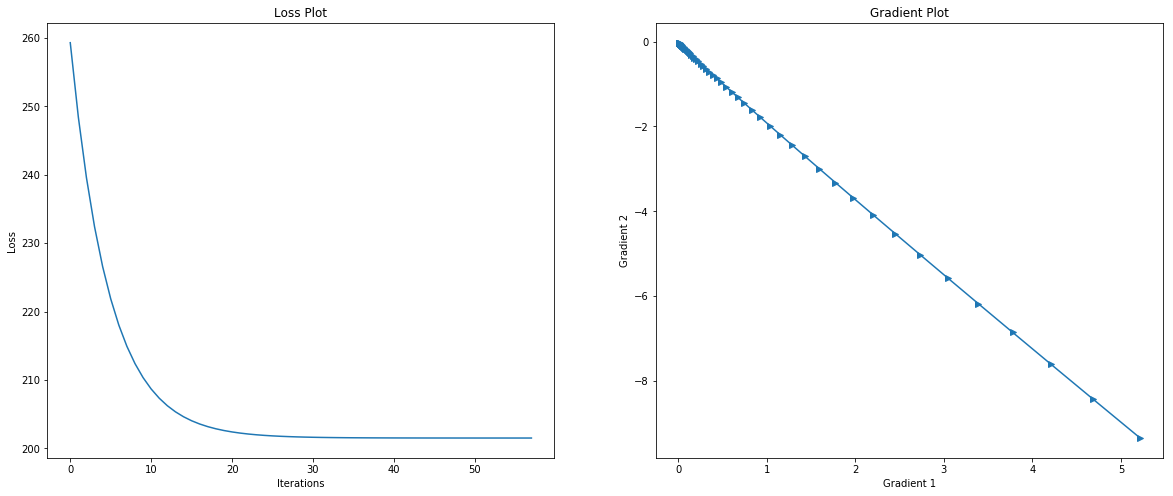

In [5]:
itr, gd_final_theta, gd_returned_thetas, gd_returned_loss_values, gd_returned_gradients = gradient_descent(x,y,5,5,0.1,100,0.0001)

print ("Iterations made before marginal improvement break:", itr ,"\n")

print("Scikitlearn values: ", intercept , slope)
print("Gradient descent values:", gd_final_theta[0] , gd_final_theta[1] )

fig, arr = plt.subplots(1,2,figsize=(20,8))

arr[0].plot(np.arange(len(gd_returned_loss_values)), gd_returned_loss_values)
arr[0].set_xlabel("Iterations")
arr[0].set_ylabel("Loss")
arr[0].set_title("Loss Plot")


arr[1].plot(gd_returned_gradients[:,0], gd_returned_gradients[:,1], '->')
arr[1].set_xlabel("Gradient 1")
arr[1].set_ylabel("Gradient 2")
arr[1].set_title("Gradient Plot")
plt.show()


<div class="alert alert-success">
The gradient descent algorithm uses the total data points at each epoch, which makes the gradient takes small steps towards the optimal point. We can see that the loss function decreases slowly and reaches the break value when the marginal value is met (Number of epochs around 60).
</div>

<div class="alert alert-block alert-info">
<strong>Question 2.</strong> Plot the regression line, along with the training data, given the coefficients $\theta$ that you have obtained with Gradient Descent.
</div>

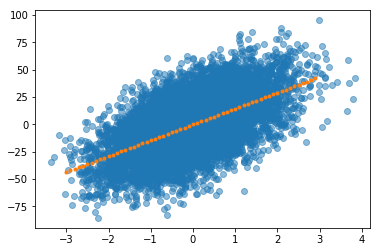

In [6]:
function = (np.array([np.zeros(x.size)+1,x])).T.dot(gd_final_theta)

slope, intercept,_,_,_ = stats.linregress(x,function)
best_fit = np.vectorize(lambda x: x * slope + intercept)
plt.plot(x,y, 'o', alpha=0.5)
grid = np.arange(-3,3,0.1)
plt.plot(grid,best_fit(grid), '.')

<div class="alert alert-block alert-info">
<strong>Question 3.</strong> Plot a 3D surface representing: on the x,y axes the parameter values, on the z axis the loss value. Additionally, plot the trajectory of the loss function on the 3D surface, using the history you collected in the gradient_descent function you designed.

Finally, plot a contour projection of the 3D surface, along with the corresponding projection of the trajectory followed by your Gradient Descent algorithm.
</div>

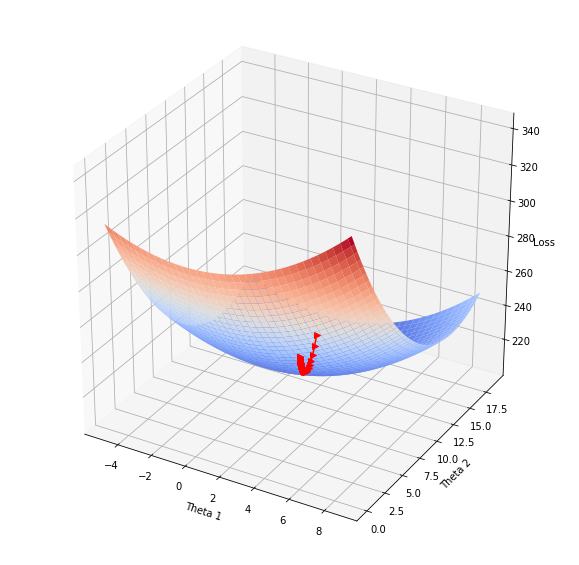

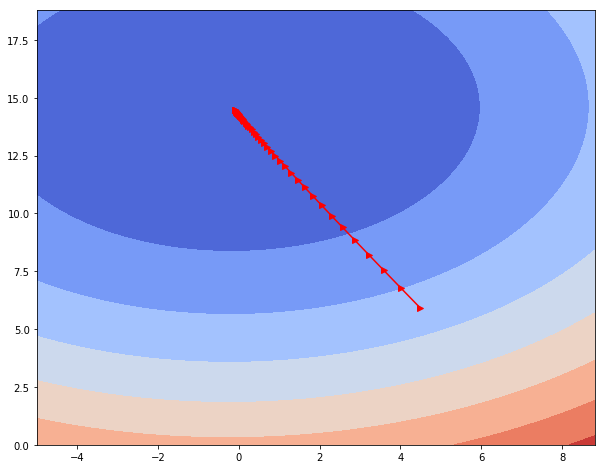

In [6]:
fig = plt.figure()
fig.set_size_inches(10, 10)
ax = fig.gca(projection='3d')

plane1_minmax = [int(np.amin(gd_returned_thetas[:,0])), int(np.amax(gd_returned_thetas[:,0]))]
plane2_minmax = [int(np.amin(gd_returned_thetas[:,1])), int(np.amax(gd_returned_thetas[:,1]))]

plane1 = np.arange(plane1_minmax[0]-5, plane1_minmax[1]+5,0.2)
plane2 = np.arange(plane2_minmax[0]-5, plane2_minmax[1]+5,0.2)

z = np.ones((len(plane2),len(plane1)))
plane1,plane2 = np.meshgrid(plane1,plane2)

for i in range (0,plane1.shape[0]):
    for j in range(0,plane1.shape[1]):
        loss = 0
        for k in range (0,len(x)):
            to_sum =plane1[i][j] + plane2[i][j]*x[k] - y[k]
            loss += to_sum * to_sum
        loss = 0.5 * loss / len(x)
        z[i][j] = loss      
        
ax.plot_surface(plane1, plane2, z, cmap=cm.coolwarm)
ax.set_xlabel("Theta 1")
ax.set_ylabel("Theta 2")
ax.set_zlabel("Loss")

plt.plot(gd_returned_thetas[:, 0], gd_returned_thetas[:, 1], gd_returned_loss_values, "r->")
plt.show()

fig = plt.figure()
fig.set_size_inches(10, 8)
plt.contourf(plane1, plane2, z, cmap=cm.coolwarm)
plt.plot(gd_returned_thetas[:, 0], gd_returned_thetas[:, 1], "r->")
plt.show()

<div class="alert alert-block alert-info">
<strong>Question 4.</strong> Plot the path the gradient takes from its initial to its final position.

This is a two dimensional plot (because our parameter vector has size 2), with a point for each gradient value, and a line connecting the points.
</div>

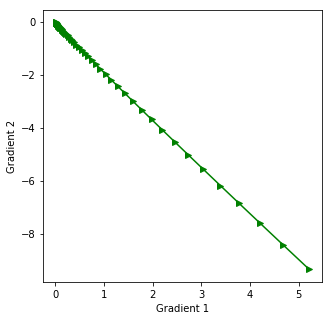

In [7]:
#Gradients plot of direction and position change
fig = plt.figure()
fig.set_size_inches(5,5)
plt.plot(gd_returned_gradients[:,0], gd_returned_gradients[:,1], 'g->')
plt.xlabel("Gradient 1")
plt.ylabel("Gradient 2")
plt.show()

## Stochastic Gradient Descent

The gradient descent algorithm makes intuitive sense as it always proceeds in the direction of steepest descent (the gradient of $J$) and guarantees that we find a local minimum (global under certain assumptions on $J$). When we have very large data sets, however, computing $\nabla_\theta J(\theta)$ can be computationally challenging: as noted above, we must process every data point before making a single step (hence the name "batch"). 

An alternative approach to alleviate such computational costs is the Stochastic Gradient Descent method: essentially, the idea is to update the parameters $\theta$ sequentially (one data point at the time), with every observation $x_i, y_i$. Following the same notation we used for Gradient Descent, the following expression defines how to update parameters, while processing one data point at the time:

$$ \theta^{(t+1)} = \theta^{(t)} - \eta \nabla_{\theta} J_i(\theta^{(t)}) $$


The stochastic gradient approach allows us to start making progress on the minimization problem one step at the time. It is computationally cheaper, but it results in a larger variance of the loss function in comparison with batch gradient descent.

Generally, the stochastic gradient descent method will get close to the optimal $\theta$ much faster than the batch method, but will never fully converge to the local (or global) minimum. Thus the stochastic gradient descent method is useful when we are satisfied with an **approximation** for the solution to our optimization problem. 

A full recipe for stochastic gradient descent follows:

```python 
for i in range(n_epochs):
  np.random.shuffle(data)
  for example in data:
    params_grad = evaluate_gradient(loss_function, example, params)
    params = params - learning_rate * params_grad
```

The reshuffling of the data is done to avoid a bias in the optimization algorithm by providing the data examples in a particular order.

<div class="alert alert-block alert-info">
<strong>Question 5.</strong> Implement your own version of Stochastic Gradient Descent, as a serial algorithm.

Follow the guidelines below:

<ul>
    <li> Define a function to perform gradient descent. The function should accept as inputs: the training data $x$ and $y$, the initial guess for the parameters ($\theta_1$ and $\theta_2$), the learning rate. Additional arguments include the definition of the maximum number of iterations before the algorithm stops, and a second stop condition on the marginal improvment on the loss.</li>
    <li> Keep track of the values of the loss, for each iteration.</li>
    <li> Keep track of the gradient values, for each iteration.</li>
</ul>
</div>

In [26]:
#SGD
def stochastic_gradient_descent(x,y, q1,q2, learning_rate, max_iters,marg_improv):
    a = datetime.datetime.now()
    theta_array = np.array([q1,q2])
    history_gradients=[]
    history_loss=[]
    history_thetas=[]
    
    previous_loss = 10000000 #initial start value is high

    for i in range(max_iters):
        XY = np.array(list(zip(x,y)))
        np.random.shuffle(XY)
        total_gradient = []
        loss = 0
        for X_example , Y_example in  XY:
            
            tmp_grd = theta_array[0] + theta_array[1]*X_example - Y_example       
            loss += 0.5 *(tmp_grd)**2
            
            #Update thetas
            total_gradient.append(np.array([tmp_grd,tmp_grd* X_example]))
            theta_array = theta_array - learning_rate * np.array([tmp_grd,tmp_grd* X_example])
            
        #average Loss    
        loss /= len(XY)
        #print ('loss: ', loss) 
        
        #save them to history lists
        total_gradient= np.array(total_gradient)
        history_gradients.append([np.mean(total_gradient[:,0]),np.mean(total_gradient[:,1])])
        history_thetas.append(theta_array)                     
        history_loss.append(loss)
      
        if (abs(loss-previous_loss) < marg_improv):
            break #not enough improvement anymore so break
        #set the previous loss
        previous_loss = loss

    b = datetime.datetime.now()
    print("SGD Computation Time: ", str(b-a))
    #return the iteration count, final theta and the history of other 3
    return i, theta_array, np.array(history_thetas), np.array(history_loss), np.array(history_gradients) 

<div class="alert alert-block alert-info">
Once the ```stochastic_gradient_descent``` function is defined, you can generate input data according to the cell above, that use scikitlearn.
    
The output of your cell should contain the following information:
<ul>
    <li> The values of the paramters obtained through Gradient Descent optimization </li>
    <li> The values of the paramters obtained with the above cell, using scikitlearn </li>
    <li> A plot of the loss versus iterations </li>
    <li> A plot of the path the gradient takes from its initial to its final position </li>
</ul>
</div>

SGD Compotation Time:  0:00:05.077326
Number of Epoch made before marginal improvement break: 99 

Scikitlearn values:  -0.0971624928155293 14.491363004543638
Stochastic Gradient descent values: 0.3937955998457834 14.291093699335871


Text(0.5,1,'Gradient Plot')

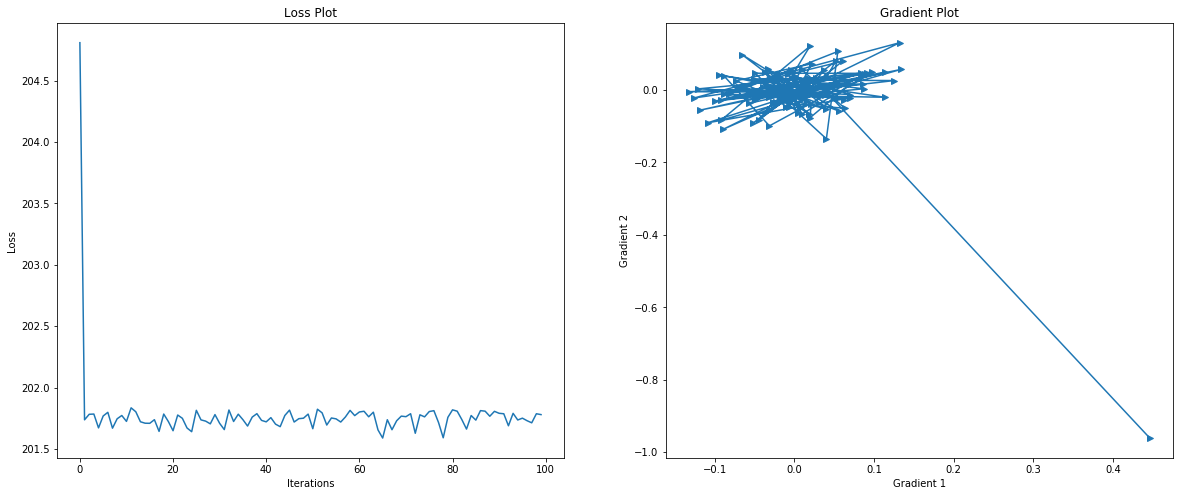

In [11]:
itr, sgd_final_theta, sgd_returned_thetas, sgd_returned_loss_values, sgd_returned_gradients = stochastic_gradient_descent(x,y,5,5,0.001,100,0.0001)

print ("Number of Epoch made before marginal improvement break:", itr ,"\n")

print("Scikitlearn values: ", intercept , slope)
print("Stochastic Gradient descent values:", sgd_final_theta[0] , sgd_final_theta[1] )

fig, arr = plt.subplots(1,2,figsize=(20,8))

arr[0].plot(np.arange(len(sgd_returned_loss_values)), sgd_returned_loss_values)
arr[0].set_xlabel("Iterations")
arr[0].set_ylabel("Loss")
arr[0].set_title("Loss Plot")

arr[1].plot(sgd_returned_gradients[:,0], sgd_returned_gradients[:,1], '->')
arr[1].set_xlabel("Gradient 1")
arr[1].set_ylabel("Gradient 2")
arr[1].set_title("Gradient Plot")

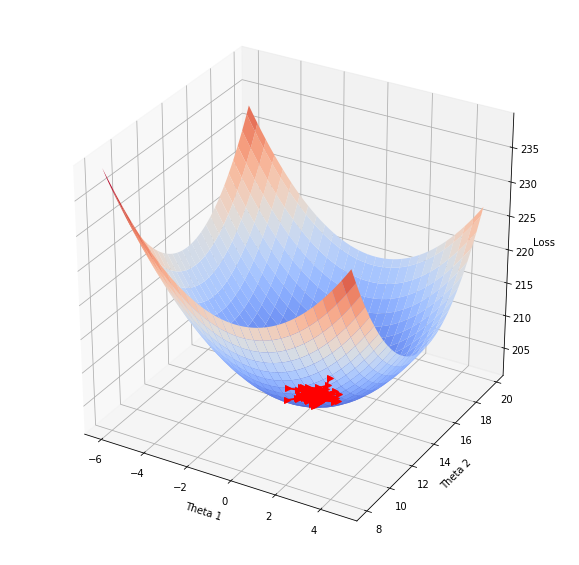

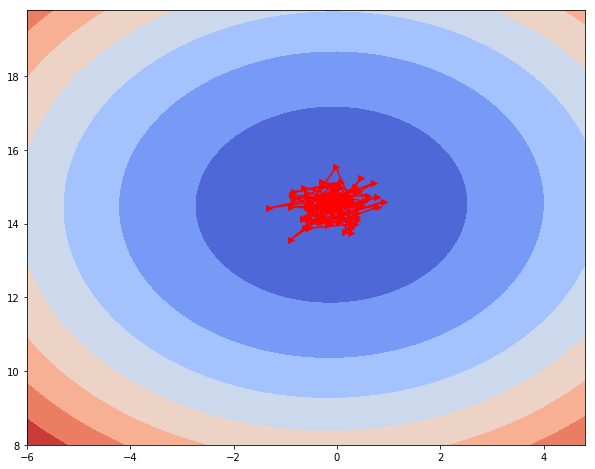

In [12]:
fig = plt.figure()
fig.set_size_inches(10, 10)

ax = fig.gca(projection='3d')

plane1_minmax = [int(np.amin(sgd_returned_thetas[:,0])), int(np.amax(sgd_returned_thetas[:,0]))]
plane2_minmax = [int(np.amin(sgd_returned_thetas[:,1])), int(np.amax(sgd_returned_thetas[:,1]))]

plane1 = np.arange(plane1_minmax[0]-5, plane1_minmax[1]+5,0.2)
plane2 = np.arange(plane2_minmax[0]-5, plane2_minmax[1]+5,0.2)

z = np.ones((len(plane2),len(plane1)))
plane1,plane2 = np.meshgrid(plane1,plane2)


for i in range (0,plane1.shape[0]):
    for j in range(0,plane1.shape[1]):
        losss = 0
        for k in range (0,len(x)):
            to_sum =plane1[i][j] + plane2[i][j]*x[k] - y[k]
            losss += to_sum * to_sum
        losss = 0.5 * losss /len(x)
        z[i][j] = losss       
        
ax.plot_surface(plane1, plane2, z, cmap=cm.coolwarm)
ax.set_xlabel("Theta 1")
ax.set_ylabel("Theta 2")
ax.set_zlabel("Loss")

plt.plot(sgd_returned_thetas[:, 0], sgd_returned_thetas[:, 1], sgd_returned_loss_values, "r->")
plt.show()

fig = plt.figure()
fig.set_size_inches(10, 8)
plt.contourf(plane1, plane2, z, cmap=cm.coolwarm)
plt.plot(sgd_returned_thetas[:, 0], sgd_returned_thetas[:, 1], "r->")
plt.show()

<div class="alert alert-success">
The stochastic GD perform updates for each sample in the dataset. We can see that it reaches the the optimal θ quickly (depends on the learning rate chosen). This method works faster than the batch method, it reaches the surrounding of the optimal θ, but doesn't converge as we can see in the figure. It keeps on oscilliating around it.
We can say that this method is useful in an opproxiation problem. 
For small learning rate, the algorithm reaches the optimal θ with more steps the for high Learning rate and the loss function is smoother.
</div>

## Mini-batch Stochastic Gradient Descent

Mini-batch gradient descent is a trade-off between stochastic gradient descent and batch gradient descent.  In mini-batch gradient descent, the cost function (and therefore gradient) is averaged over a small number of samples, which is what we call the mini-batch, and that we denote by $mb$.  This is opposed to the SGD batch size of 1 sample, and the BGD size of all the training samples. 

Let's use the notation we introduced above to rewrite the gradients in matrix form for the mini-batch variant:

$\nabla_\theta J(\theta) =  \frac{1}{2 mb} \sum_{i=1}^{mb} \nabla_\theta (x_i \theta - y_i)^2$


$= \sum_{i=1}^{mb} (x_i \theta - y_i) x_i^T =$


$= x_{mb}^T (x_{mb} \theta - y_{mb})$


What’s the benefit of doing it this way?  First, it smooths out some of the noise in SGD, but not all of it, thereby still allowing the “kick” out of local minimums of the cost function.  Second, the mini-batch size is still small, thereby keeping the performance benefits of SGD.





<div class="alert alert-block alert-info"> 
<strong>Question 6.</strong> Implement your own version of Mini-batch Stochastic Gradient Descent, as a serial algorithm.

Follow the guidelines below:

<ul>
    <li> Define a function to extract mini-batches from the training data.
    <li> Define a function to perform gradient descent. The function should accept as inputs: the training data $x$ and $y$, the initial guess for the parameters ($\theta_1$ and $\theta_2$), the learning rate. Additional arguments include the definition of the maximum number of iterations before the algorithm stops, and a second stop condition on the marginal improvment on the loss.</li>
    <li> Keep track of the values of the loss, for each iteration.</li>
    <li> Keep track of the gradient values, for each iteration.</li>
</ul>

</div>

In [27]:
#MINI BATCH SGD

def next_batch(x,y,b_size):
    for i in np.arange(0,len(x),b_size):
        yield(x[i:i+b_size],y[i:i+b_size])

def mini_batch_stochastic_gradient_descent(x,y, q1,q2, learning_rate, max_iters,marg_improv, b_size = 50):
    a = datetime.datetime.now()  
    theta_array = np.array([q1,q2])
    
    history_gradients=[]
    history_loss=[]
    history_thetas=[]
    
    previous_loss = 10000000 #initial start value is high
   
    XY = np.array(list(zip(x,y)))
    for i in range(max_iters): 
        np.random.shuffle(XY)
        total_gradient = []
        tmp_loss = 0
        x,y= zip(*XY)
        for X_batch , Y_batch in next_batch(x,y,b_size):
            x_ones = np.array([np.ones(b_size),X_batch]) #array of all 1s
            
            #calculate theta, loss and grad for this iteration
            tmp_theta = x_ones.T.dot(theta_array)
            tmp_loss += 0.5*(tmp_theta-Y_batch).dot((tmp_theta-Y_batch).T)/b_size
            tmp_grad = x_ones.dot(tmp_theta-Y_batch)/b_size
            
            total_gradient.append(tmp_grad)
            theta_array = theta_array - learning_rate * tmp_grad
            
        #average Loss    
        tmp_loss /= (len(x)/b_size)
        #print ('loss: ', loss)
       
        #save them to history lists
        total_gradient= np.array(total_gradient)
        history_gradients.append([np.mean(total_gradient[:,0]),np.mean(total_gradient[:,1])])
        history_thetas.append(theta_array)
                                 
        history_loss.append(tmp_loss)
      
        if (abs(tmp_loss-previous_loss) < marg_improv):
            break #not enough improvement anymore so break
        #set the previous loss
        previous_loss = tmp_loss

    b = datetime.datetime.now()
    print("MB-SGD Computation Time: ", str(b-a))
    #return the iteration count, final theta and the history of other 3
    return i, theta_array, np.array(history_thetas), np.array(history_loss), np.array(history_gradients) 

<div class="alert alert-block alert-info"> 
Once the ```gradient_descent``` function is defined, you can generate input data according to the cell above, that use scikitlearn.

The output of your cell should contain the following information:
<ul>
    <li> The values of the paramters obtained through Gradient Descent optimization </li>
    <li> The values of the paramters obtained with the above cell, using scikitlearn </li>
    <li> A plot of the loss versus iterations </li>
    <li> A plot of the path the gradient takes from its initial to its final position </li>
</ul>
</div>

MB-SGD Compotation Time:  0:00:00.529116
Number of Epoch made before marginal improvement break: 30 

Scikitlearn values:  -0.0971624928155293 14.491363004543638
Stochastic Gradient descent values: -0.09777196423294986 14.496856333328353


Text(0.5,1,'Gradient Plot')

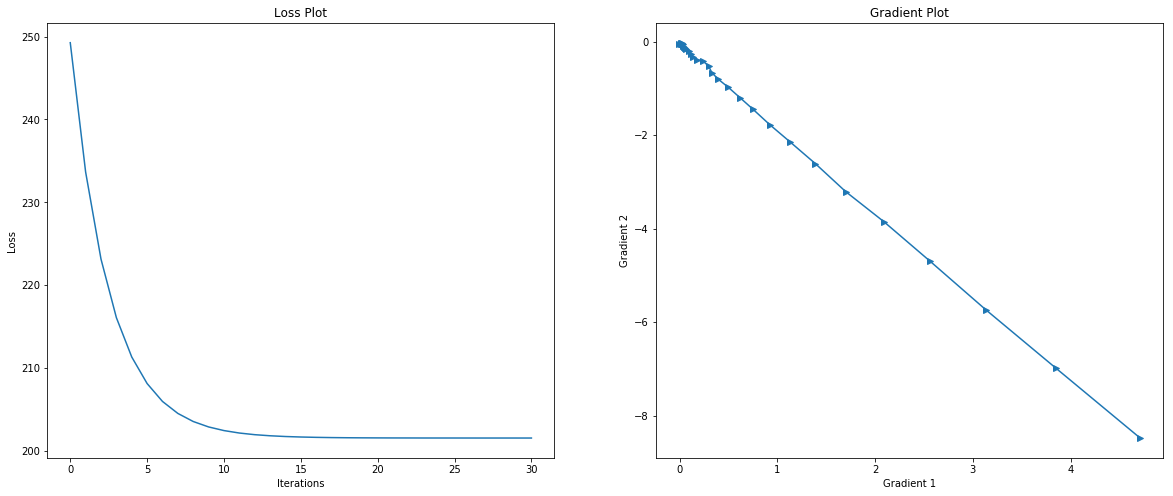

In [14]:
#Batch size is 50 here, we can try different ones
itr, mbsgd_final_theta, mbsgd_returned_thetas, mbsgd_returned_loss_values, mbsgd_returned_gradients = mini_batch_stochastic_gradient_descent(x,y,5,5,0.001,100,0.0001, b_size=50)

print ("Number of Epoch made before marginal improvement break:", itr ,"\n")

print("Scikitlearn values: ", intercept , slope)
print("Stochastic Gradient descent values:", mbsgd_final_theta[0] , mbsgd_final_theta[1] )

fig, arr = plt.subplots(1,2,figsize=(20,8))

arr[0].plot(np.arange(len(mbsgd_returned_loss_values)), mbsgd_returned_loss_values)
arr[0].set_xlabel("Iterations")
arr[0].set_ylabel("Loss")
arr[0].set_title("Loss Plot")

arr[1].plot(mbsgd_returned_gradients[:,0], mbsgd_returned_gradients[:,1], '->')
arr[1].set_xlabel("Gradient 1")
arr[1].set_ylabel("Gradient 2")
arr[1].set_title("Gradient Plot")

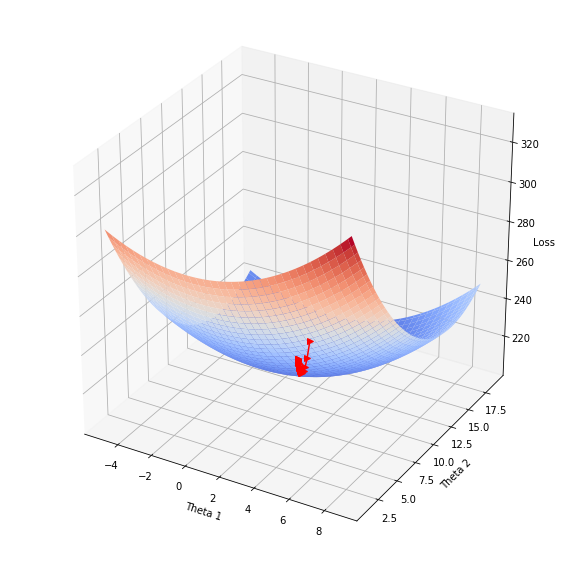

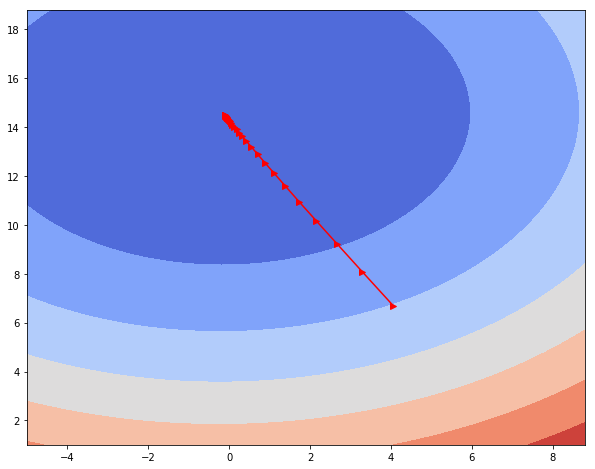

In [15]:
fig = plt.figure()
fig.set_size_inches(10, 10)

ax = fig.gca(projection='3d')

plane1_minmax = [int(np.amin(mbsgd_returned_thetas[:,0])), int(np.amax(mbsgd_returned_thetas[:,0]))]
plane2_minmax = [int(np.amin(mbsgd_returned_thetas[:,1])), int(np.amax(mbsgd_returned_thetas[:,1]))]

plane1 = np.arange(plane1_minmax[0]-5, plane1_minmax[1]+5,0.2)
plane2 = np.arange(plane2_minmax[0]-5, plane2_minmax[1]+5,0.2)

z = np.ones((len(plane2),len(plane1)))
plane1,plane2 = np.meshgrid(plane1,plane2)

for i in range (0,plane1.shape[0]):
    for j in range(0,plane1.shape[1]):
        losss = 0
        for k in range (0,len(x)):
            to_sum =plane1[i][j] + plane2[i][j]*x[k] - y[k]
            losss += to_sum * to_sum
        losss = 0.5 * losss /len(x)
        z[i][j] = losss
        
        
ax.plot_surface(plane1, plane2, z, cmap=cm.coolwarm)
ax.set_xlabel("Theta 1")
ax.set_ylabel("Theta 2")
ax.set_zlabel("Loss")

plt.plot(mbsgd_returned_thetas[:, 0], mbsgd_returned_thetas[:, 1], mbsgd_returned_loss_values, "r->")
plt.show()

fig = plt.figure()
fig.set_size_inches(10, 8)
plt.contourf(plane1, plane2, z, cmap=cm.coolwarm)
plt.plot(mbsgd_returned_thetas[:, 0], mbsgd_returned_thetas[:, 1], "r->")
plt.show()

<div class="alert alert-success">
The mini-batch stochastic gradient descent is updating every mini_batch ( a small batch of samples). Unlike the batch GD, it is not taking the whole dataset and unlike the stochastic GD it is not taking sample by sample.
We can see that the results of the algorithms are reaching the optimal faster than the batch GD, with fewer steps (Depends on LR), and as for oscillation we can see that is has lower oscillations and reaches the marginal improvement with less number of epochs compared to the stochastic gradient descent.
</div>

<div class="alert alert-block alert-info">
<strong>Question 7.</strong> Compare the loss rate of the three approachs, Gradient Descent, Stochastic Gradient Descent, Mini-batch Stochastic Gradient Descent, by plotting in the same figure, the loss rate as a function of iterations. 


Comment the behavior of the three algorithms.
</div>

Test 1: Learning Rate 0.1
GD Compotation Time:  0:00:00.004986
SGD Compotation Time:  0:00:05.229548
MB-SGD Compotation Time:  0:00:01.854217
MB-SGD Compotation Time:  0:00:01.626652


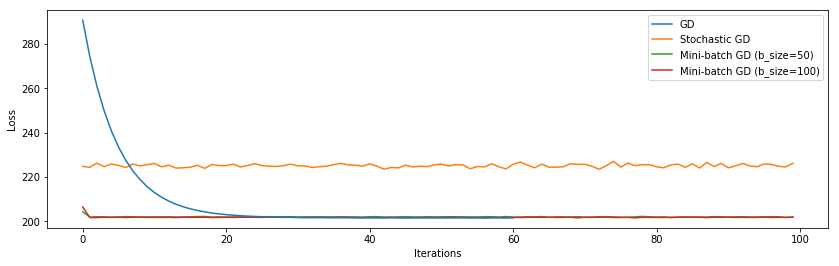

Test 2: Learning Rate 0.001
GD Compotation Time:  0:00:00.006981
SGD Compotation Time:  0:00:05.040644
MB-SGD Compotation Time:  0:00:00.708820
MB-SGD Compotation Time:  0:00:00.797348


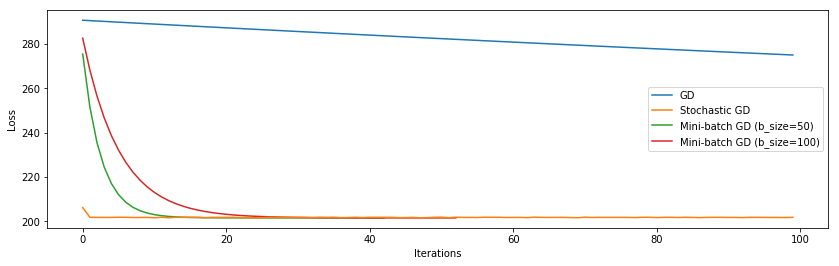

In [16]:
#Loss function with 0.1 learning rate
print("Test 1: Learning Rate 0.1")
fig, ax = plt.subplots(figsize=(14,4))

batch_GD_loss = gradient_descent(x,y,0,1,0.1,100,0.0001)[3]
plt.plot(np.arange(batch_GD_loss.size), batch_GD_loss, label="GD", zorder=3)

stochastic_GD_loss = stochastic_gradient_descent(x,y,0,1,0.1,100,0.0001)[3]
plt.plot(np.arange(stochastic_GD_loss.size), stochastic_GD_loss, label="Stochastic GD",zorder=2)

mini_batch50_GD_loss = mini_batch_stochastic_gradient_descent(x,y,0,1,0.1,100,0.0001,b_size=50)[3]
plt.plot(np.arange(mini_batch50_GD_loss.size), mini_batch50_GD_loss, label="Mini-batch GD (b_size=50)", zorder=1)

mini_batch100_GD_loss = mini_batch_stochastic_gradient_descent(x,y,0,1,0.1,100,0.0001,b_size=100)[3]
plt.plot(np.arange(mini_batch100_GD_loss.size), mini_batch100_GD_loss, label="Mini-batch GD (b_size=100)", zorder=1)

plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()

#Loss function with 0.001 learning rate
print("Test 2: Learning Rate 0.001")
fig, ax = plt.subplots(figsize=(14,4))

batch_GD_loss = gradient_descent(x,y,0,1,0.001,100,0.0001)[3]
plt.plot(np.arange(batch_GD_loss.size), batch_GD_loss, label="GD", zorder=3)

stochastic_GD_loss = stochastic_gradient_descent(x,y,0,1,0.001,100,0.0001)[3]
plt.plot(np.arange(stochastic_GD_loss.size), stochastic_GD_loss, label="Stochastic GD",zorder=2)

mini_batch50_GD_loss = mini_batch_stochastic_gradient_descent(x,y,0,1,0.001,100,0.0001,b_size=50)[3]
plt.plot(np.arange(mini_batch50_GD_loss.size), mini_batch50_GD_loss, label="Mini-batch GD (b_size=50)", zorder=1)

mini_batch100_GD_loss = mini_batch_stochastic_gradient_descent(x,y,0,1,0.001,100,0.0001,b_size=100)[3]
plt.plot(np.arange(mini_batch100_GD_loss.size), mini_batch100_GD_loss, label="Mini-batch GD (b_size=100)", zorder=1)

plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()

<div class="alert alert-success">
For the same data size, the same initial thetas, we can see that we have different behavior of the 3 algorithms. SGD converges faster than normal "batch" gradient descent because it updates after looking at a randomly selected data on each epoch. However by looking at a random batch seems to converge much better with a good batch size that can represent a good data set rather than a one sample.
<br>
<br>
For a high Learning rate = 0.1 (first figure), we can see that the Batch GD started from high Loss values, to reach slowly the minimal loss and the improvement marginal. The stochastic min batch doesn't reach the the minimum value of the loss, since it doesn't converge the optimal thetas and keeps on oscilliating around it, which explains the small oscillations that we have in the loss function. The mini_batch SD reaches since the first epochs the optimal thetas, but since that in this case we have high learning rate, so the step took are big, and it doesn't reach the improvement marginal so it keeps on oscilliating around it.
<br>
<br>
For a low Learning rate, we can see that we have different behavior, in term of the loss reaches, the smoothness of the loss and the number of iterations.
For the Batch GD, since the steps are small, so it will need bigger number of iterations to reach the optimal values. For the stochastic Gradient descent, we have less oscilations and the loss is lower than with high LR.
As for the mini_batch GD, we can see that the loss has decresed slowly, unlike Stochastic GD, the reach the minium loss and stop the algorithms at few (40) number of iterations once converging to the minimum.
<br>
<br>
Also it is important to note that for example on high learning rate Batch GD and on low learning rate Mini-Batch GD actually did not need 100 iterations. The marginal loss gain threshold is reached before epoch 60 and stopped the altorithm. Which directly affects the computation time we see. Maybe we should also print computation time per iteration to see the real time complexity among them.
<br>
<br>
Finally the Mini-BatchGD batch size directly affects the direction of loss slope. However there is a tradeoff here. Low batch size will result in a noisy training direction where as higher batch size will take longer to compute each step. The model should optimise both in order to provide good learning ratio with a fast computation and progress of descent. (Please notice batch size 100 took longer than batch size 50)

</div>

***

## Distributed Mini-Batch Stochastic Gradient Descent
We're now ready to study the problem of distributed, mini-batch stochastic gradient descent. Clearly, so far we've worked with very small datasets: as a consequence it is hard to appreciate the computational bottleneck of serial implementations. But before we delve into an experimental setting, and try to spice things up with larger datasets, let's focus on the problem per se.

The problem statement is as follows: we need to design a distributed version of the algorithm we examined above, that is the Mini-Batch Stochastic Gradient Descent. In the interest of time, and also because in this laboratory we want to work with Apache Spark, we will look at **synchronous** distributed algorithms. Don'y worry, things will be much more clear in the next section!

As a complement to this introduction, here's a list of references that are useful for this Notebook, and more generally that constitute the base for those of you interested in distributed optimization algorithms, an important element of large-scale machine learning.

The first reference is a research paper that was published in 2010, in a very important conference called NIPS. I suggest to have a look at section 1 only, unless you want to pursue a PhD, in which case I strongly suggest to contact me, I'm always looking for bright students to work with!

The following references are a collection of pointers to real code, which essentially implement the ideas presented in the research paper we mentioned. Beware, this is Scala code, whereas we use Python. Nevertheless, you'll find a lot of inspiring hints for your own code. Again, I suggest to start simple, and avoid the regularization part. On another note, it is interesting to look at code that is meant to be integrated as a contribution to a popular open source software, such as Apache Spark, and in particular MLLib. This is in stark contrast to the "coding style" we adopt in this Notebook, which is to be considered experimental, and far from being compliant with any principled approach to software engineering.


#### References
* Parallelized Stochastic Gradient Descent: http://martin.zinkevich.org/publications/nips2010.pdf
* https://github.com/yu-iskw/spark-parallelized-sgd/blob/master/src/main/scala/org/apache/spark/mllib/optimization/ParallelizedSGD.scala
* https://github.com/yu-iskw/spark-parallelized-sgd/blob/master/src/main/scala/org/apache/spark/mllib/optimization/SGDUpdater.scala
* https://github.com/yu-iskw/spark-parallelized-sgd/blob/master/src/test/scala/org/apache/spark/mllib/optimization/ParallelizedSGDSuite.scala

### Some useful hints to design your distibuted algorithm

In this Notebook we will use Apache Spark, which is simply a fantastic tool! As we've learned in class (and this is actually true for Hadoop MapReduce as well as for any other distributed computing framework embracing the Bulk Synchrnous Parallel (BSP) programming model), Apache Spark features a synchronization barrier that really helps in dealing with distributed computations. To simplify the discussion (a much more profound treatment of the subject can be found in this nice book http://www.parallel-algorithms-book.com/), in Apache Spark workers operate synchronously, in that the result of their computation, when aggregated or distributed, is processed only when **all** workers are done. So on the one hand, this simplifies the programming model, while on the other hand, this might introduce "stragglers", that is slow workers that penalize the performance of your distributed algorithm.

So what are the basic steps you should follow to design and implement your distributed algorithm?

#### Algorithm pseudo-code
In what follows, we outline the algorithm pseudo-code, to help you think about your algorithm implementation.

```python
for i in range(iterations)
  
  # Randomly partition the input, giving T examples to each machine.
  mini_batches = sample(input_data)

  # Initialize random paramters
  params = initialize
  
  # This part executes in parallel, on each of the k worker machines
  # This is essentially the same code as for the serial implementation
  # Indeed, we're working on an embarassingly parallel formulation
  for data in mini_batch: 
    params_grad = evaluate_gradient(loss_function, example, params)
    params = params - learning_rate * params_grad
    
  # Here we aggregate from all machines, and compute the update for iteration i
  # The update is simply the average of all updates coming from each of the k worker machines
  Aggregate from all computers params = average(params_k)
```

#### Input data and parameters
As for the input data, we want to use the same procedure we used from the beginning of the Notebook: we use scikit learn to generate our $x$ and $y$.
Then, you have to find ways to **partition** this data across the machines you have in your cluster. The method ```sc.parallelize``` comes handy here.

Once you have a parallel collection, that takes the form of an ```RDD```, you'll have to ```sample``` from it, to create random mini batches, each of which will be used **independently** by each worker machine to process its own data. Be careful that here we want to **keep the data partitioning** of our original data. You should be wise enough to lookup for the PySpark API to get the details of the methods we suggested here: ```sample``` and ```mapPartitions```.

Last but not least, we have to take care about the parameters! The initial parameter values, as well as any updates to them, must be shipped to all worker machines. There are various ways to do this, exploiting the great flexibility of Apache Spark. This data could be serialized and shipped along with the code each task should execute. However, a much more efficient method to do this is to exploit what we have learned in class, namely ```broadcast variables```. You might argue that for our simple Notebook, since the parameter vector is of size 2, this is not a big deal. However, for different scenarios, like big models, having an efficient primitive to ship a lot of data to workers is a big plus: remember that broadcast variables are sent to workers using a protocol very similar to BitTorrent, a famous peer-to-peer content distribution system.

#### Driver vs. workers

Now, to clarify even further what we expect from our Apache Spark program, here's some additional information about the roles of each component invovled in the execution of the pseudo-code outlined above.


Essentially, the ```driver``` machine (the one where the ```SparkContext``` is created), is the one responsible for executing the "serial" part of the algorithm: prepare and dispatch data, and wait for the contributions coming from all machines.


Instead, the ```worker``` machines receive their task to execute, proceed independently (some faster than others), and send their updates to the driver. The driver will **wait for all updates from workers** before proceeding with the final aggregation.

#### Additional hints

As you might have heard in class, Apache Spark has a lot of surprises. On of such cool methods allow you to define the way data is aggregated. Indeed, you surely realized that (in the old Hadoop MapReduce jargon) we're talking about a "map only job": workers "map" on their minibatch, computing partial gradient updates, then send everything (more or less at the same time) to the driver machine. At the scale of this Notebook, this is rather harmless. Instead, at larger scale, this could create "congestion" in the driver: a nice solution to this would be to have the possibility to aggregate data along a tree-structure, which would involve worker machines as well as the driver.


One final note. In case you wonder how to produce an ```iterable``` in python with a singleton in it, just ```return (variable, )```.

<div class="alert alert-block alert-info">
<strong>Question 8.</strong> Implement your own version of Mini-Batch, Stochastic Gradient Descent, as a **distributed** algorithm.

    
The output of your cell should contain the following information:
<ul>
<li> The values of the paramters obtained through Gradient Descent optimization </li>
<li> The values of the paramters obtained with the above cell, using scikitlearn </li>
<li> A plot of the loss versus iterations </li>
<li> A plot of the path the gradient takes from its initial to its final position </li>
</ul>
</div>

In [10]:
from pyspark import SparkContext
#For Local Device use SparkContext() for Zoe not required
#sc = SparkContext()
sc

<SparkContext master=local[*] appName=pyspark-shell>

In [28]:
#DISTRIBUTED MINI BATCH STOCHASTIC GRADIENT DESCENT#
#Maybe we could put parallisation and partitioning variables or random mini batches percentage as parameter here.
def dist_mini_batch_stochastic_gradient_descent(x,y, q1,q2, learning_rate, max_iters,marg_improv):
    a = datetime.datetime.now()
    #partition data across the machines we have in the cluster. 
    NbrPartitions = 4
    
    # Initialize paramters
    theta_1 = sc.broadcast(q1)
    theta_2 = sc.broadcast(q2)
    learning_rate_b = sc.broadcast(learning_rate)
    
    def iterable_stochastic_gradient_descent(data):
        loss = 0
        gradient = 0
        nbr_samples =0

        for X_example , Y_example in data:      
            #calculate theta, loss and grad for this iteration
            thetas= np.array([theta_1.value,theta_2.value])

            #Calculate the gradient
            tmp_grd = thetas[0] + thetas[1]*X_example - Y_example
            
            #cumulate the loss
            loss += 0.5 *(tmp_grd)**2
            
            #cumulate the gradient        
            gradient += np.array([tmp_grd,tmp_grd* X_example])
                      
            #Update thetas
            thetas = thetas - learning_rate_b.value * np.array([tmp_grd,tmp_grd* X_example])
            nbr_samples = nbr_samples +1 
       
        return ([thetas,gradient/nbr_samples,loss/nbr_samples],  )
    
    #input data  
    xy = np.array(list(zip(x,y))) 
    rdd = sc.parallelize(xy, NbrPartitions) # we have 4 workers in our Cluster
    print("Number of partitions: {}".format(rdd.getNumPartitions()))
    
    history_gradients=[]
    history_loss=[]
    history_thetas=[]
    
    previous_loss = 10000000 #initial loss value is high
    for i in range(max_iters):
        
        #create random mini batches
        #get a random percentage(60%) sample of rdd 
        mini_batch = rdd.sample(False,0.6,50*i)

        # This part executes in parallel, on each of the k worker machines
        #Map phase then the Reduce phase
        maptimer_start = datetime.datetime.now()    
        #apply the stochastic_gradient_descent function on the whole partitions
        resultmap = mini_batch.mapPartitions(iterable_stochastic_gradient_descent)
        maptimer_end = datetime.datetime.now()
        #print("mapPartitions: Computation Time: ", maptimer_end-maptimer_start)
        
        reducetimer_start = datetime.datetime.now() 
        # Here we aggregate from all machines, and compute the update for iteration i 
        #sum the output of all the workers
        result = resultmap.reduce(lambda workerx, workery : [workerx[0]+workery[0] ,workerx[1]+workery[1], workerx[2]+workery[2]] )
        reducetimer_end = datetime.datetime.now() 
        #print("Reduce: Computation Time: ", reducetimer_end-reducetimer_start)
        
        # The update is the average of all updates coming from each of the k worker machines
        theta_array = result[0]/NbrPartitions #Thetas
        total_gradient = result[1]/NbrPartitions #Gradients
        total_loss = result[2]/NbrPartitions #loss
        
        #save them to history lists
        history_gradients.append(total_gradient)
        history_thetas.append(theta_array)                         
        history_loss.append(total_loss)
        
        theta_1 = sc.broadcast(theta_array[0])
        theta_2 = sc.broadcast(theta_array[1])
        
        if(i%100 == 0):
            print('Iteration:',i," Loss:", total_loss)
        
        if (abs(total_loss-previous_loss) < marg_improv):
            break #not enough improvement anymore so break
 
        #set the previous loss
        previous_loss = total_loss
    b = datetime.datetime.now()
    print("DistributedMB-SGD Computation Time: ", str(b-a))
    #return the iteration count, final theta and the history of other 3
    return i, theta_array, np.array(history_thetas), np.array(history_loss), np.array(history_gradients) 

<div class="alert alert-success">

We used 4 partitions as our laptops had that many cores during working. On ZOE we have 6 cores so we could push this even more. Also we use rdd.sample to choose from 60% of the dataset, causing some iterations to actually increase the loss rather than decreasing it. Usually this situation happens after 750 iterations. See results below:

</div>

Number of partitions: 4
('Iteration:', 0, ' Loss:', 262.27325703321617)
('Iteration:', 100, ' Loss:', 249.44203082947416)
('Iteration:', 200, ' Loss:', 241.68977600216556)
('Iteration:', 300, ' Loss:', 233.76089639054786)
('Iteration:', 400, ' Loss:', 227.026339442609)
('Iteration:', 500, ' Loss:', 225.83435522664695)
('Iteration:', 600, ' Loss:', 224.1477715855063)
('Iteration:', 700, ' Loss:', 222.14452798552293)
('Iteration:', 800, ' Loss:', 222.8739750501985)
('Iteration:', 900, ' Loss:', 221.77261312056868)
('DistributedMB-SGD Computation Time: ', '0:01:41.733269')
('Iterations made before marginal improvement break:', 999, '\n')
Scikitlearn values:
('Intercept: ', -0.09716249281552888)
('Slope: ', 14.49136300454365)

Distributed Mini Batch Stochastic Gradient descent values:
('Intercept: ', 5.505072924609573)
('Slope: ', 12.691900399500339)


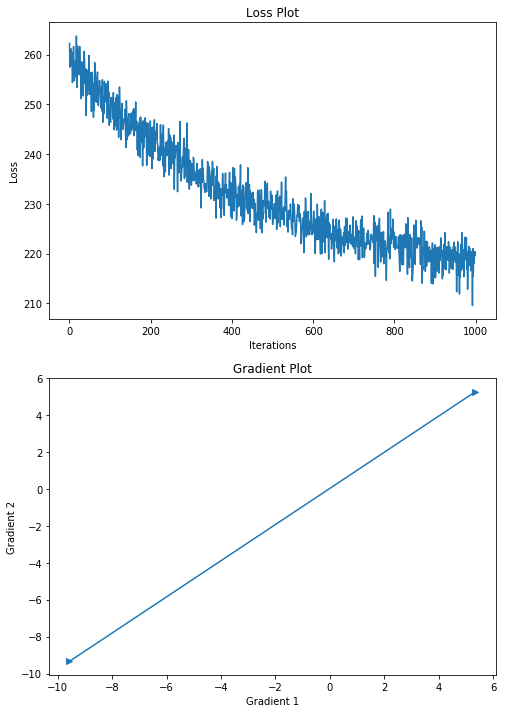

In [20]:
itr, dist_final_theta, dist_returned_thetas, dist_returned_loss_values, dist_returned_gradients = dist_mini_batch_stochastic_gradient_descent(x,y,5,5,0.001,1000,0.0001)
print ("Iterations made before marginal improvement break:", itr ,"\n")

print("Scikitlearn values:")
print("Intercept: ", intercept)
print("Slope: ", slope)
print("\nDistributed Mini Batch Stochastic Gradient descent values:")
print("Intercept: ", dist_final_theta[0])
print("Slope: ", dist_final_theta[1])


fig, arr = plt.subplots(2)
fig.subplots_adjust(hspace=0.2)
fig.set_size_inches(8, 12)

arr[0].plot(np.arange(len(dist_returned_loss_values)), dist_returned_loss_values)
arr[0].set_xlabel("Iterations")
arr[0].set_ylabel("Loss")
arr[0].set_title("Loss Plot")


arr[1].plot(dist_returned_gradients[0], dist_returned_gradients[1], '->')
arr[1].set_xlabel("Gradient 1")
arr[1].set_ylabel("Gradient 2")
arr[1].set_title("Gradient Plot")
plt.show()

<div class="alert alert-warning">
  <strong>Warning!</strong><br>
  This process works good on Zoe but it gives very weird results on local machines as parallalisation depends on the cores, threads and resources available by the system that is running it.
  <br>
  By default spark.locality.wait is set to 3 seconds. "Spark will wait to launch a task on an executor local to the data using this value. After this period if the data-local node is still unavailable, Spark will give up and launch the task on another less-local node." (For more info check this <a href="https://support.datastax.com/hc/en-us/articles/208237373-FAQ-When-is-it-a-good-idea-to-set-Spark-locality-wait-to-zero-">resource</a>)
  <br><br>
  Oddly speaking, distributed training worked great on our laptop's local Spark Environment(Linux, i7-8700HQ 6 cores) whereas it took 3seconds*iterations on our Desktop local Spark Environment(Windows, i5-7600k 4 cores). The difference should be originated from the Spark configurations (by default windows version initialized Spark with 1 worker that we need to configure up to core number ourselves) or the CPU support (not likely an issue as we had 4 cores) of the desktop computer for parallelisation.
</div>

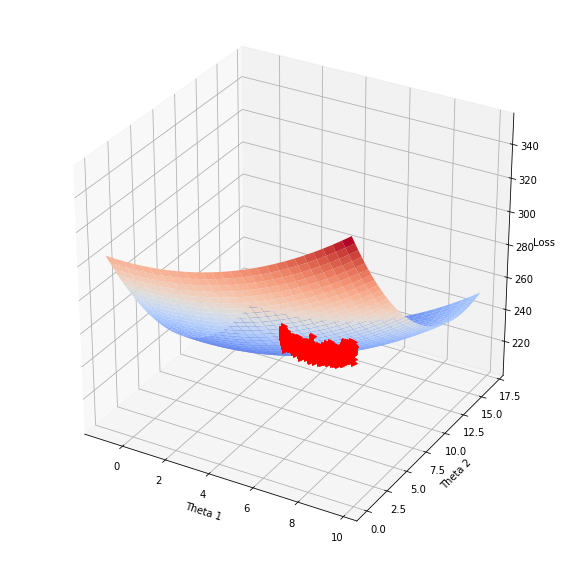

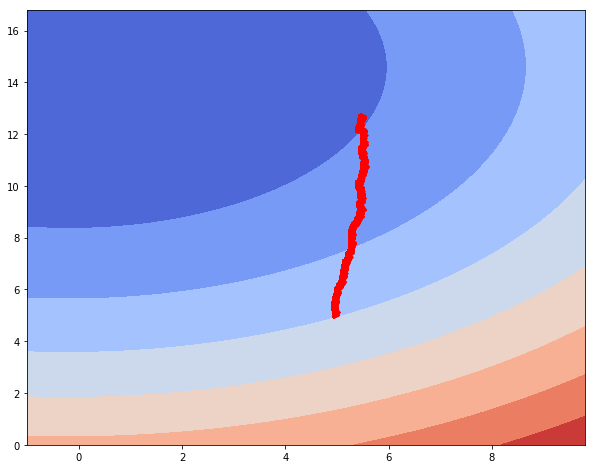

In [21]:
fig = plt.figure()
fig.set_size_inches(10, 10)
ax = fig.gca(projection='3d')

plane1_minmax = [int(np.amin(dist_returned_thetas[:,0])), int(np.amax(dist_returned_thetas[:,0]))]
plane2_minmax = [int(np.amin(dist_returned_thetas[:,1])), int(np.amax(dist_returned_thetas[:,1]))]

plane1 = np.arange(plane1_minmax[0]-5, plane1_minmax[1]+5,0.2)
plane2 = np.arange(plane2_minmax[0]-5, plane2_minmax[1]+5,0.2)

z = np.ones((len(plane2),len(plane1)))
plane1,plane2 = np.meshgrid(plane1,plane2)

for i in range (0,plane1.shape[0]):
    for j in range(0,plane1.shape[1]):
        losss = 0
        for k in range (0,len(x)):
            to_sum =plane1[i][j] + plane2[i][j]*x[k] - y[k]
            losss += to_sum * to_sum
        losss = 0.5 * losss /len(x)
        z[i][j] = losss   
        
ax.plot_surface(plane1, plane2, z, cmap=cm.coolwarm)
ax.set_xlabel("Theta 1")
ax.set_ylabel("Theta 2")
ax.set_zlabel("Loss")

plt.plot(dist_returned_thetas[:, 0], dist_returned_thetas[:, 1], dist_returned_loss_values, "r->")
plt.show()

fig = plt.figure()
fig.set_size_inches(10, 8)
plt.contourf(plane1, plane2, z, cmap=cm.coolwarm)
plt.plot(dist_returned_thetas[:, 0], dist_returned_thetas[:, 1], "r->")
plt.show()

<div class="alert alert-block alert-info">
<strong>Question 9.</strong> Inspecting your input data, and its partitioning.
<br>

Answer the following questions:
<ul>
    <li>What is the best way to partition your data, given your cluster configuration? How many partitions did you chose</li>
    <li>Given the number of partitions from the first point, how many RDD blocks is your data broken into?</li>
    <li>What would be different if you were to concieve the same algorithm digesting input data stored as a CSV file on HDFS? Argue about how to "ship" data to worker machines, partitions, blocks, etc...</li>
</ul>
</div>


**```[HINT]```** The questions above are best answered by looking at the Spark Master Web UI.

<div class="alert alert-success">
  <strong>Answers</strong>
  <br>
  <ul>
  <li>
    Having a lot or a few partitions both have advantages and disadvantages. If you have too few partitions you will not benefit from parallelism. You will end up with less concurrency and some workers might stay idle for long periods of times. Also with few partitions your data might skew on different partitions causing unbalanced resource usage among workers and disability to utilise the whole storage properly. On the other hand if you have too many partitions your task scheduling might take too much time and cause time complexity. In our case if we will have 4 workers that will work on batches, it is a good approach to ensure that the partitions will contain exact multiples of this value, therefore workers can perfectly fetch one batch without spreading to different partitions or block one another. <a href="https://techmagie.wordpress.com/2015/12/19/understanding-spark-partitioning/">This source</a> suggests that lower bound of partition should be 2xcores available to applications, whereas being sure no to have too many to cause the task scheduling to consume too much time.
  </li>
  <li>
<i>rdd = sc.parallelize(xy, NbrPartitions)</i> splits our data into 4 Partitions(NbrPartitions variable in the code). By printing RDD.getNumPartitions() we proved that our RDD in fact have that many.
  
  </li>
  
  <li>
    Firstly, in Spark by default a partition is created for every HDFS partition of size 64MB. RDDs are automatically partitioned in spark if the developer does not interfere with the partitioning scheme. But let us assume we want to ship a very big dataset.csv file from the HDFS. The parallelise will no longer actually do the parallalisation here anymore, but there are still other ways to make it possible. We can create distributed datasets on PySpark by using Hadoop storage source for HDFS, which can store different blocks of our csv file on different storages on different machines! Spark driver can retrieve the location of the end node and schedule workers to do the work on those blocks. Which in the end makes parallisation possible once more. Ideally speaking, the workers would work much faster on local devices where the data is stored to reduce the actual data transfers.
  </li>
</ul>
</div>

<div class="alert alert-block alert-info">
<strong>Question 10.</strong> Finding bottlenecks.

<ul>
    <li>What is the bottleneck in the current implementation of your algorithm?</li>
    <li>Can you nail down exactly which method is causing this bottleneck?</li>
    <li>Can you suggest ways to mitigate or eliminate the bottleneck?</li>
</ul>
</div>

<div class="alert alert-success">
  <strong>Answers</strong>
  <br>
  <ul>
  <li>
      The current bottleneck is caused by the 1 to N relation from the driver to the workers(N). Everytime driver broadcasts data to workers, for each iteration it has to wait all workers to complete their tasks to retrieve the results, prepare the next iteration data and repeat all over again. Spark spends linear time with regards to number of partitions which becomes the bottleneck in our implementation. Multiplied with the number of iterations, this bottleneck results in a huge delay of the algorithm. As the dataset size grows, the results that needs to be reduced will also increase because the data being distributed will be very very big. On larger scales, we can see this delay much better. (Refer to Q11 for largely scaled datasets and observe the bottleneck effect there)
      
  </li>
  <li>
    The method that is causing the bottleneck is mapPartitions as all workers need to finish their tasks before moving on to the next iteration.
  </li>
 
  <li>
 We can eliminate the bottleneck by trying to make the processing workload of all the worker is the same, that they are similar machines, have similar other jobs running, by that we can reduce the waitng time of the driver. We could also divide the data up differently. By increasing the number of partitions, the effect of stragglers would be reduced as the free partitions could be assigned to fast workers.
</li>
</ul>
</div>

<div class="alert alert-block alert-info">
<strong>Question 11.</strong> Comparison of serial vs. distributed algorithms.
</div>

Given all the implementation effort you did so far, this question is about an experimental study on scalability. Given input data sizes in the range $[10^2, 10^3, 10^4, 10^5]$, collect the run-time and the loss rate at convergence for all variants of the serial algorithms and for the distributed one. Produce a plot with 2 y-axis, one for the run-time, one for the loss rate, and one x-axis with the input data size.

Discuss your results.


In [39]:
import time

def make_regression_n(numData):
    x,y = make_regression(n_samples = numData, 
                       n_features=1, 
                       n_informative=1, 
                       noise=20,
                       random_state=2017)
    x = x.flatten()
    return x,y
time_f = []
loss_f = []
functions =[gradient_descent,stochastic_gradient_descent,mini_batch_stochastic_gradient_descent,dist_mini_batch_stochastic_gradient_descent]
LR = [0.1,0.001,0.001,0.001]
print("Testing for different learning rates, 100 iterations each function")
for i in range(0,4):
    #for every input data 
    numData = pow(10, i+2) #testing with different data sizes
    x,y = make_regression_n(numData)
    # get the loss and time of every function 
    timel = []
    lossl = []
    j=0
    for function in functions:
        start = time.time()
        _, _, _, loss,_ = function(x,y,5,5,LR[j],100,0.0001)
        end = time.time()
        t_run = end-start
        timel.append(t_run)
        lossl.append(loss[-1])
        j+=1
    time_f.append(timel)
    loss_f.append(lossl)   

Testing for different learning rates, 100 iterations each function
('GD Computation Time: ', '0:00:00.001461')
('SGD Computation Time: ', '0:00:00.060981')
('MB-SGD Computation Time: ', '0:00:00.018942')
Number of partitions: 4
('Iteration:', 0, ' Loss:', 2631.5854596736067)
('DistributedMB-SGD Computation Time: ', '0:00:08.532628')
('GD Computation Time: ', '0:00:00.003022')
('SGD Computation Time: ', '0:00:00.547806')
('MB-SGD Computation Time: ', '0:00:00.134516')
Number of partitions: 4
('Iteration:', 0, ' Loss:', 1417.9505046845838)
('DistributedMB-SGD Computation Time: ', '0:00:09.571260')
('GD Computation Time: ', '0:00:00.008313')
('SGD Computation Time: ', '0:00:05.354115')
('MB-SGD Computation Time: ', '0:00:00.566530')
Number of partitions: 4
('Iteration:', 0, ' Loss:', 262.27325703321617)
('DistributedMB-SGD Computation Time: ', '0:00:10.248421')
('GD Computation Time: ', '0:00:00.025016')
('SGD Computation Time: ', '0:00:53.148419')
('MB-SGD Computation Time: ', '0:00:01.2

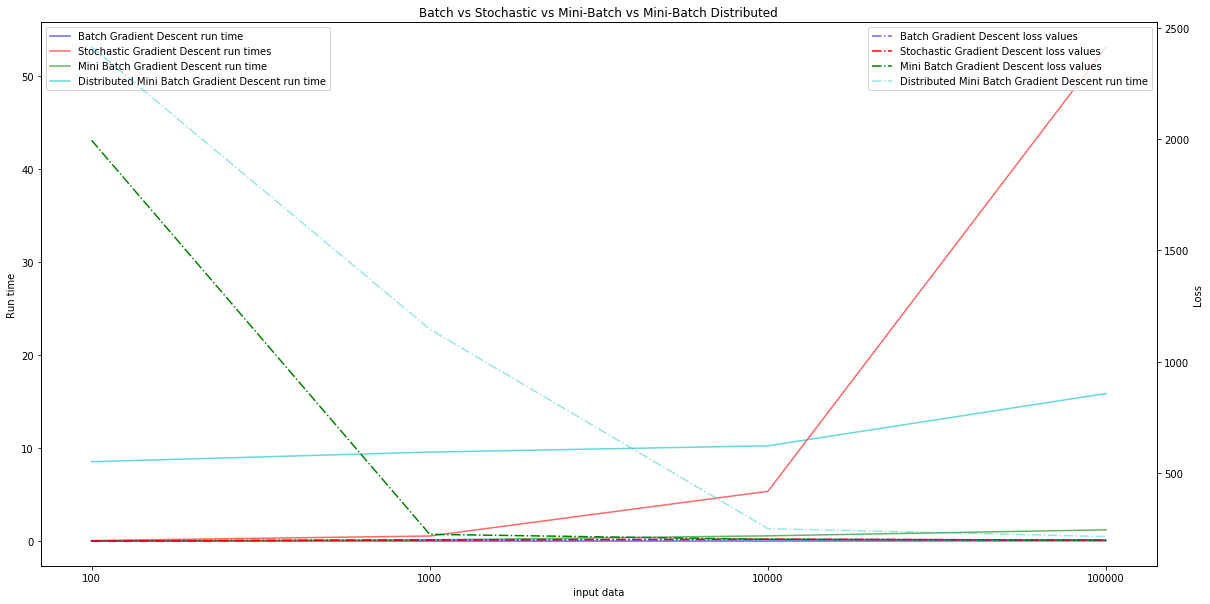

In [40]:
time_f=np.array(time_f)  
loss_f=np.array(loss_f)
# SET UP
fig, ax1 = plt.subplots(figsize=(20,10))
ax2 = ax1.twinx()
my_xticks = ["100","1000","10000","100000"]
xticks = np.arange(0,4)
plt.xticks(xticks,my_xticks)
ax1.set_xlabel('input data')

# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('Run time')
ax1.tick_params('y')
ax2.set_ylabel('Loss')
ax2.tick_params('y')

## GRADIENT DESCENT PLOT
ax1.plot(xticks, time_f[:,0], 'b-', label='Batch Gradient Descent run time', alpha=0.6)
ax2.plot(xticks, loss_f[:,0], 'b-.', label='Batch Gradient Descent loss values', alpha=0.6)

## STOCHASTIC GRADIENT DESCENT PLOT
ax1.plot(xticks,time_f[:,1], 'r-', label='Stochastic Gradient Descent run times', alpha=0.6)
ax2.plot(xticks, loss_f[:,1], 'r-.', label='Stochastic Gradient Descent loss values')

## MINI-BATCH GRADIENT DESCENT PLOT
ax1.plot(xticks, time_f[:,2], 'g-', label='Mini Batch Gradient Descent run time', alpha=0.6)
ax2.plot(xticks, loss_f[:,2], 'g-.', label='Mini Batch Gradient Descent loss values')

## MINI-BATCH DISTRIBUTED GRADIENT DESCENT PLOT
ax1.plot(xticks, time_f[:,3], 'c-', label='Distributed Mini Batch Gradient Descent run time', alpha=0.6)
ax2.plot(xticks, loss_f[:,3], 'c-.', label='Distributed Mini Batch Gradient Descent run time', alpha=0.4)

# add titles and legend
plt.title("Batch vs Stochastic vs Mini-Batch vs Mini-Batch Distributed")
ax1.legend()
ax2.legend()

plt.show()

<div class="alert alert-success">
  <strong>Comments</strong>
  <br>
  It is not very hard to see that the Batch and MiniBatch gradient functions actually scale linearly with the dataset size. As the size increase the dataset they need to loop increase linearly and increase their runtime similarly. (Still 100.000 was not a big enough value to actually see this because they ran still under 1sec all the time. Maybe we could try millions to see a real change). Looping 100K values in 100K or choosing 1K batches of 100 times actually is a linear scaling compared to 1000 value being split to 10x100 times batches. Ergo, the scaling seems to be linear.(of course in reality it would not be perfectly linear but close to say N complexity), the batch size plays an imprtant role here, keeping it low(1) would make it look similar to SGD while keeping it very high would make it look similar to Batch GD in the end. (We could try a dynamic batch size here, 1% or 0.1% of dataset size, but hey you don't know the data set size all the time, so let it stay this way(50 right now)!)
  <br>
  <br>
  On the other hand, the run time of Distributed function and Stochastic descent changed rapidly with the data set size. For stochactic descent this is normal as it converges to a good minimum point and saturates around it all the time so it takes all its time, as the dataset increases the points it needs to loop also scales. While for distributed descent the run time increases slightly as in the end it is being distributed to multiple workers, the overhead time complexity is due to the fact that reduction and random sampling takes longer than earlier. In the end it provides much much better results when dataset grows. However on small datasets, distributed descent takes the longest time as distributing and reducing back takes much longer than just looping it locally on one machine.
  <br>
  <br>
  It is important to note that, the distributed performance could be increased easyly if we would use a bigger cluster with more workers to do the work in parallel, while the others would not scale well on very very big data sets like that. Also, tuning the distribution configurations better with regards to the data size (in terms of sampling rate, partitioning, etc) would definitely give better results than this. Even this way, it gives the best result and best training across numerous epochs on bigger datasets. Notice somewhere between 10K and 100K dataset size, we started to benefit greatly from the distributed approach as the loss became better than others, while the runtime overhead is almost eliminated completely, making it a great approach for big sized data sets. Whereas it started the worst on smaller data sets because of the map/reduce run time being insanely long, and the loss is very high due to sampling rate 60% not being good enough to represent the total dataset yet(imagine you have 10 points and you ignore 4 of them randomly. leftover 6 might not enough to figure out where the minumum is)
  <br>
  <br>
  Finally commenting the loss values, it really would be wrong to compare them like this. The reason is simple, each algorithm actually performs better on different learning rate, and some breaks earlier than 100 or 1000 iterations if marginal improvement threshold is breached with that given learning rate. To simplify, we cant give learning rate 1 to SGD and 0.1 to GD and say SGD has terrible results, or similarly even using same LR one would perform better than another. Or maybe on low learning rate one would surpass another if given 10K iterations. In the end it is all about the trade-off on how long do we want to run and how much performance we want to achieve, how close is close enough to the minimum point, etc.
  
  </div>